In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

# Step 1: Load the data
# ---------------------
# For this example, let's assume we're working with stock data (time series data).
# We'll use a CSV file that contains columns like 'Date', 'Open', 'High', 'Low', 'Close', and 'Volume'.
# You can replace 'your_stock_data.csv' with the actual file path or download stock data using APIs.

# Load the data into a pandas DataFrame

# CREATE TICKER INSTANCE FOR AMAZON
amzn = yf.Ticker("AMZN")

# GET TODAYS DATE AND CONVERT IT TO A STRING WITH YYYY-MM-DD FORMAT (YFINANCE EXPECTS THAT FORMAT)
end_date = datetime.now().strftime('%Y-%m-%d')
data = amzn.history(start='2022-01-01',end=end_date)

# Preview the data to ensure it's loaded correctly
print(data['Open'].head())  # Display the first few rows

Date
2022-01-03 00:00:00-05:00    167.550003
2022-01-04 00:00:00-05:00    170.438004
2022-01-05 00:00:00-05:00    166.882996
2022-01-06 00:00:00-05:00    163.450500
2022-01-07 00:00:00-05:00    163.839005
Name: Open, dtype: float64


In [ ]:

# Step 2: Data Cleaning
# ---------------------
# Data cleaning involves handling missing values, formatting dates, and ensuring correct data types.
# We'll focus on the 'Close' column for the SMA calculation, but this process can be expanded to other columns if needed.

# 2.1 Handle Missing Values
# Check for missing values in the DataFrame
print(data.isnull().sum())  # Display number of missing values per column

print('_______CLEANED_______')
# Fill missing values with the forward fill method (filling using the last valid observation)
data.ffill(inplace = True)

# Ensure no more missing values remain
print(data.isnull().sum())

# 2.2 Format Date Column (if necessary)
# Convert the 'Date' column to a datetime object for easier manipulation



Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
_______CLEANED_______
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [ ]:

# Step 3: Calculate the Simple Moving Average (SMA)
# -------------------------------------------------
# The Simple Moving Average (SMA) is calculated by taking the average price over a specific time window.
# We'll use a window size of 20 days as an example (you can adjust this for different time frames).

def calculate_sma(data, window_size):
    """
    Calculate Simple Moving Average (SMA) for a given time window.

    Parameters:
    data (pd.Series): The data to calculate SMA on (e.g., closing prices).
    window_size (int): The size of the moving window.

    Returns:
    pd.Series: The SMA values as a pandas Series.
    """
    # Use the rolling() function to create a rolling window and calculate the mean
    sma = data.rolling(window=window_size).mean()
    return sma

# Apply the SMA function to the 'Close' column with a window size of 20
data['SMA_20'] = calculate_sma(data['Close'], 20)

# Apply another SMA with a longer window size, say 50 days (for strategy comparison)
data['SMA_50'] = calculate_sma(data['Close'], 50)


print(data['SMA_20'].head)


<bound method NDFrame.head of Date
2022-01-03 00:00:00-05:00           NaN
2022-01-04 00:00:00-05:00           NaN
2022-01-05 00:00:00-05:00           NaN
2022-01-06 00:00:00-05:00           NaN
2022-01-07 00:00:00-05:00           NaN
                                ...    
2024-10-14 00:00:00-04:00    187.533501
2024-10-15 00:00:00-04:00    187.574001
2024-10-16 00:00:00-04:00    187.597001
2024-10-17 00:00:00-04:00    187.480001
2024-10-18 00:00:00-04:00    187.349501
Name: SMA_20, Length: 703, dtype: float64>


In [ ]:

# Step 4: Strategy: SMA Crossover
# --------------------------------
# A common trading strategy involves using two SMAs:
# - A short-term SMA (e.g., 20-day) and a long-term SMA (e.g., 50-day).
# The strategy generates a buy signal when the short-term SMA crosses above the long-term SMA (bullish crossover).
# Conversely, it generates a sell signal when the short-term SMA crosses below the long-term SMA (bearish crossover).

def generate_signals(data):
    """
    Generate buy/sell signals based on SMA crossover strategy.

    Parameters:
    data (pd.DataFrame): The stock data with SMA columns.

    Returns:
    pd.DataFrame: The data with an additional 'Signal' column.
    """
    # Initialize a 'Signal' column with 0 (no action)
    data['Signal'] = 0

    # Generate buy signal: when the short-term SMA (SMA_20) crosses above the long-term SMA (SMA_50)
    data['Signal'][data['SMA_20'] > data['SMA_50']] = 1

    # Generate sell signal: when the short-term SMA (SMA_20) crosses below the long-term SMA (SMA_50)
    data['Signal'][data['SMA_20'] < data['SMA_50']] = -1

    return data

# Apply the signal generation function
data = generate_signals(data)


<ipython-input-16-b993b5cf8f79>:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][data['SMA_20'] > data['SMA_50']] = 1
<ipython-input-16-b993b5cf8f79>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

**For the future**

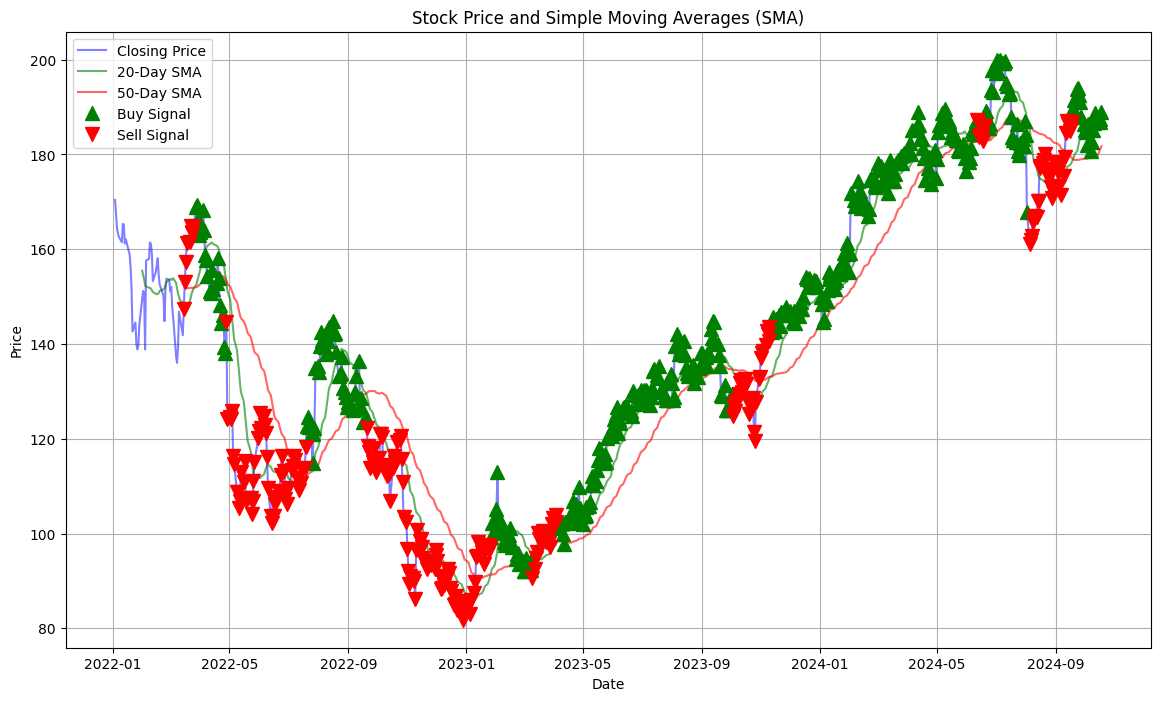

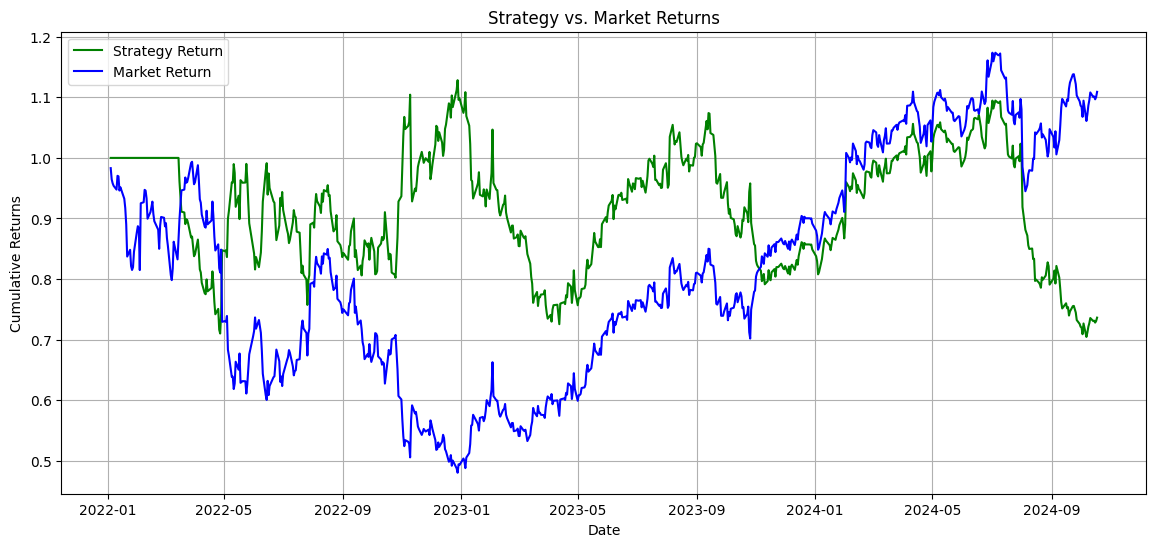

In [ ]:

# Step 5: Backtesting the Strategy
# --------------------------------
# Now that we have buy and sell signals, let's simulate a basic backtesting approach.
# The goal is to see how the strategy performs by calculating returns.

def backtest_strategy(data):
    """
    Backtest the SMA crossover strategy by calculating the returns.

    Parameters:
    data (pd.DataFrame): The stock data with signals and close prices.

    Returns:
    pd.DataFrame: Data with added returns and strategy performance.
    """
    # Calculate daily returns based on the 'Close' price
    data['Daily_Return'] = data['Close'].pct_change()

    # Calculate strategy returns: if we are in a buy (1), take the return, else 0
    data['Strategy_Return'] = data['Daily_Return'] * data['Signal'].shift(1)

    # Calculate the cumulative return over the period (this gives a sense of strategy performance)
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

    # Similarly, calculate the cumulative return of simply holding the stock
    data['Cumulative_Market_Return'] = (1 + data['Daily_Return']).cumprod()

    return data

# Backtest the strategy
data = backtest_strategy(data)

# Step 6: Visualizing the Results
# -------------------------------
# We'll plot the stock price, the two SMAs, and the buy/sell signals, as well as strategy vs. market returns.

def plot_data(data):
    """
    Plot the stock price, SMA indicators, and buy/sell signals.

    Parameters:
    data (pd.DataFrame): The stock data with SMAs and signals.
    """
    plt.figure(figsize=(14, 8))

    # Plot the closing price
    plt.plot(data.index, data['Close'], label='Closing Price', color='blue', alpha=0.5)

    # Plot the 20-day and 50-day SMAs
    plt.plot(data.index, data['SMA_20'], label='20-Day SMA', color='green', alpha=0.6)
    plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='red', alpha=0.6)

    # Highlight buy signals (SMA_20 > SMA_50)
    plt.plot(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')

    # Highlight sell signals (SMA_20 < SMA_50)
    plt.plot(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

    # Add titles and labels
    plt.title('Stock Price and Simple Moving Averages (SMA)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()

# Plot the results
plot_data(data)

# Plot the cumulative returns of the strategy vs. the market
def plot_returns(data):
    plt.figure(figsize=(14, 6))

    # Plot cumulative returns
    plt.plot(data.index, data['Cumulative_Strategy_Return'], label='Strategy Return', color='green')
    plt.plot(data.index, data['Cumulative_Market_Return'], label='Market Return', color='blue')

    # Add titles and labels
    plt.title('Strategy vs. Market Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()

# Plot strategy vs market returns
plot_returns(data)

# Step 7: Conclusion
# ------------------
# This code outlines a full process from loading and cleaning the stock data to implementing an SMA-based trading strategy.
# You can adjust window sizes and further tune the strategy based on additional technical indicators or combine it with other models.